## UK Retail Sales Time Series Forecast

### Goal
In this modeling exercise, I am going to preform time series forecast based on "sales_extended_data.csv" data file. 

### Data Source
The original data comes from Kaggle https://www.kaggle.com/carrie1/ecommerce-data/downloads/ecommerce-data.zip. It includes 12 consequtive months sales data from an online retail store. 

In order to perform time series forecast, the orginal dataset has been analyzed and pre-processed to satisfy following criteria:
- Constant interval between data point. The interval chosen is month, the data value is the net sales of the month.
- Has more than one year worth of data. Based on the existing one year sales data, 5 more years data is generated during the pre-processing and saved in "sales_extended_data.csv" file for this exercise. For de
tails of data generation, see https://github.com/sagopalm/ukretail/blob/development/UK_Retail_DataAnalysis.ipynb


,Sales
Month,
2010-12-01,1182625.03
2011-01-01,560000.26
2011-02-01,498062.65
2011-03-01,683267.08
2011-04-01,493207.12


Sales    float64
dtype: object

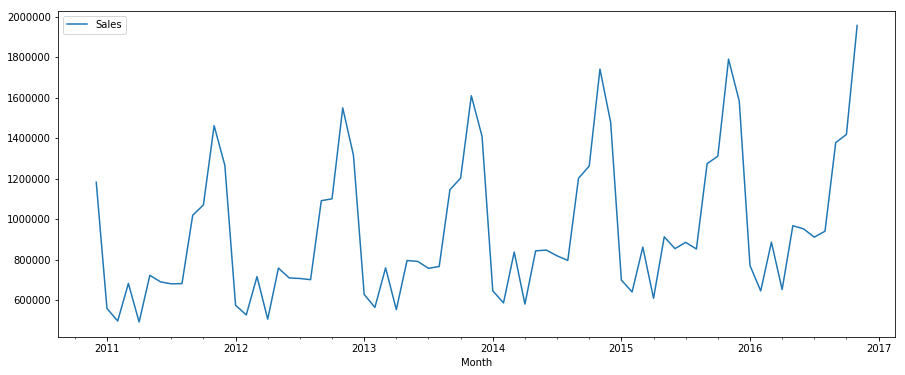

In [375]:
import pandas as pd
import matplotlib as mpl
import numpy as np
from sklearn.metrics import mean_squared_error
import warnings; warnings.simplefilter('ignore')

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# allow multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
ts = pd.read_csv('sales_extended_data.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)
ts.plot(kind='line', x=ts.index, y='Sales')
ts.head()
ts.dtypes



## Is the data source stationary?

Most of the time series models work on the assumption that the dataset is stationary over time, which means the dataset has following properties:
- constant mean 
- constant variance 
- an autocovariance that doesn't change over time

Our data above shows an overall increasing trend with seasonal variations. In order to use time series forecast, we need to remove the trend and seanonal variations from the dataset before modeling. First let's plot the series data with 12 months rolling mean and std so that we have a better understanding of the non-stationarity of the data.

In [35]:
# This function plots the series along with the 12 months rolling mean and standard deviation.

def plot_with_rolling_mean_std(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(center=False,window=12).mean()
    rolstd = timeseries.rolling(center=False,window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


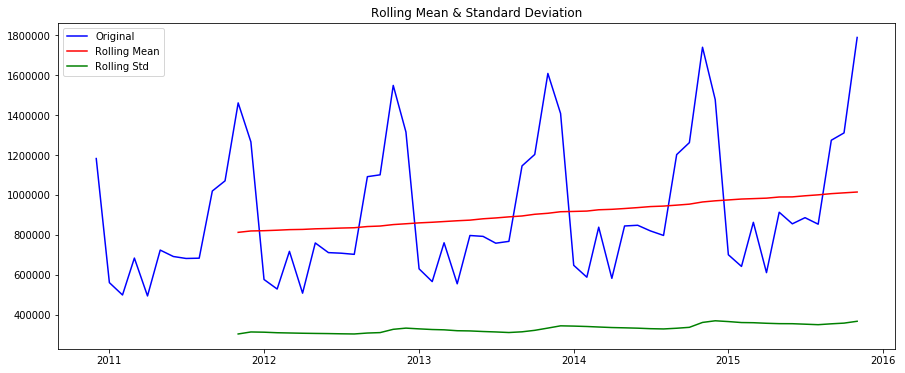

In [425]:
# set ts_test data from the first 5 years' data and plot it with the rolling mean and std
ts_test = ts['2010-12-1':'2015-11-1']
plot_with_rolling_mean_std(ts_test)

# set 6th years data for validating the model
ts_cross_validate = ts['2015-12-1':]


The red line indicates the 12-month rolling mean increases as time goes on. The green line shows that the 12-month rolling standard deviation changes with time as well. That means this time series shows clear trend and seasonality and thus is not stationary. 

Another way to test the stationarity is to use the adfuller function from statsmodels package. It performs Dickey-Fuller test on the time series data. The output of the test data includes some statistic information that can be used to decide how confident the dataset is stationary. 

In [54]:
from statsmodels.tsa.stattools import adfuller

# This function tests if a time series data is stationary

def test_stationarity(timeseries):    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [329]:
# adfuller only accept 1D data
test_stationarity(ts_test.iloc[:,0].values)

Results of Dickey-Fuller Test:
Test Statistic                  0.964928
p-value                         0.993882
#Lags Used                     11.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


The Dickey-Fuller test shows the test statistic (0.99) is greater than all critical values(all negative), which means the ts_test series is NOT stationary.

We need to remove the two main non-stationary sources from the series:
- trend: varied means over time
- seasonality: variations to specific time frame, such as a particular month or season

Then following the steps for time series forecast:
1. Estimate the trend and seasonality of a time series ts_1
2. Remove the trend and seasonality from ts_1 to make a stationary time series ts_2, also called residual
3. make statistic forecast ts_3 from ts_2
4. apply the trend and seasonality to ts_3 and get the final forecast result ts_4

### Remove Trend and Seasonailty

There are many ways of removing the trend. A very common way of doing so is the log transformation first and followed by substracting the moving average, an aggregation method to estimat and remove the trend. It is performed first as a base line result and another method will be used to compare the efeectiveness of the methods.

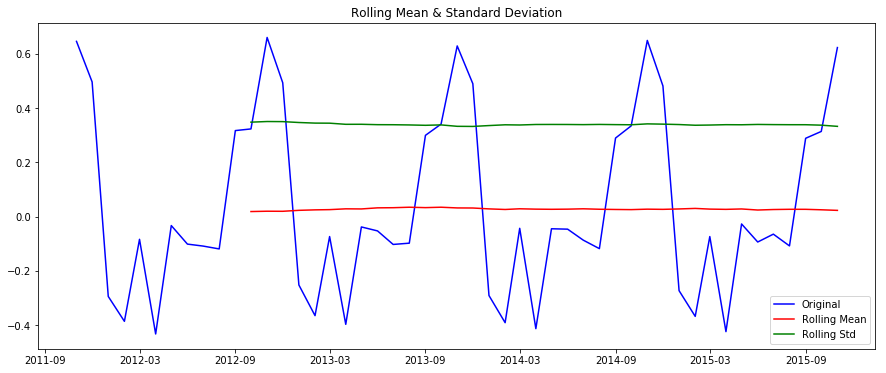

Results of Dickey-Fuller Test:
Test Statistic                 -2.147024
p-value                         0.226031
#Lags Used                     11.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


In [428]:
ts_log = np.log(ts_test)
moving_avg = ts_log.rolling(center=False,window=12).mean()
ts_log_moving_avg_diff = ts_log - moving_avg

# since the first 11 data has no moving average, we want to remove them out of the series
# Note this takes a way a large chunk of data for modeling!
ts_log_moving_avg_diff.dropna(inplace=True)

plot_with_rolling_mean_std(ts_log_moving_avg_diff)

test_stationarity(ts_log_moving_avg_diff.iloc[:,0])

Now the test statistic (-2.14) is still greater than the 10% critical value(-2.61), that means the ts_log_moving_avg_diff series is still not stationary.

Another way of removing the trend and seasonality is called **differencing** - take the difference with a particular time lag. 


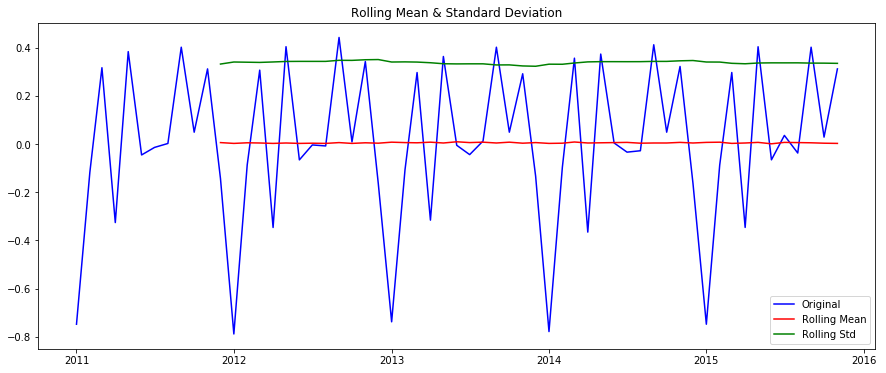

Results of Dickey-Fuller Test:
Test Statistic                -78.791721
p-value                         0.000000
#Lags Used                     10.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


In [331]:
# try different Diff_Count, it turns out 1 shift is good enough
Diff_Count = 1
ts_log_diff = ts_log - ts_log.shift(Diff_Count)
ts_log_diff.dropna(inplace=True)

plot_with_rolling_mean_std(ts_log_diff)
test_stationarity(ts_log_diff.iloc[:,0])

Now the test statistic (-78.8) is smaller than 1% cristical Value (-3.57) and we can say with 99% confidence that the ts_log_diff is stationary and can be used for the next step of modeling.

### Time Series Modeling
Next I will use [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) modeling to fit the test data and make the forecast for corss validation date.

To run ARIMA model, we need three parameters (p, d, q), where:
- d is the differnecing order, in our case it is 1, 
- p and q are can be decided by plotting the ACF and PACF against the lag count.

In [252]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=15)
lag_pacf = pacf(ts_log_diff, nlags=15, method='ols')

Text(0.5,1,'Autocorrelation Function')

Text(0.5,1,'Partial Autocorrelation Function')

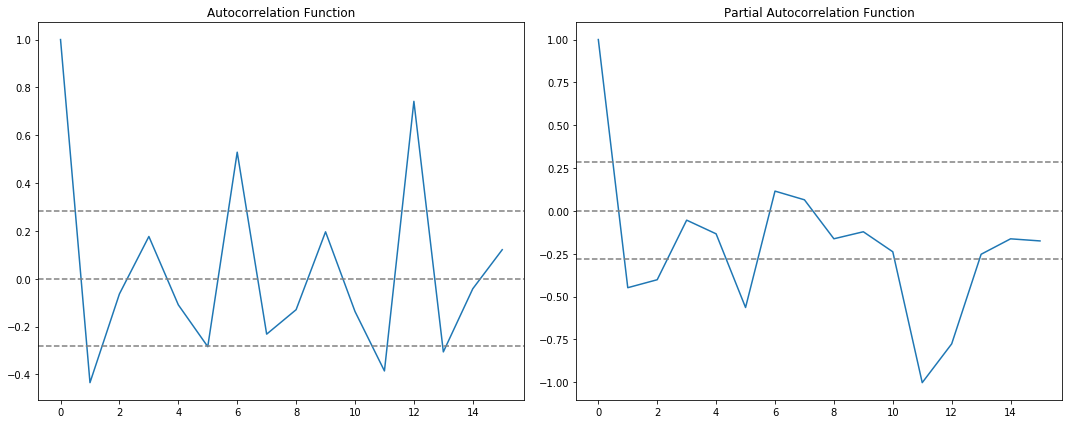

In [192]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The p = 1 and q = 1 are chosen based on the x-axis values at the intersection of PACF and ACF curves with the top most dashed line that indicats a strong positive correlation.

In [429]:
from statsmodels.tsa.arima_model import ARIMA
import math

# Set modeling paremeters
p = 1
d = 1
q = 1

Based on the different combinations of the above three paramemters, we can make three different models, let's call AR, MA and ARIMA, and compare their results before making final forecast.

### AR Model
order parameter set (p, d, 0)


Text(0.5,1,'AR model residual fitted data RSS = 6.14')

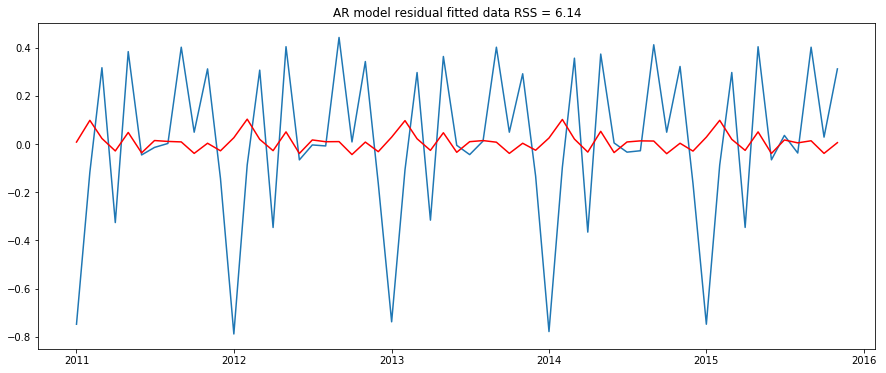

In [436]:
model = ARIMA(ts_log, order=(p, d, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('AR model residual fitted data RSS = %.2f'% math.fsum((results_AR.fittedvalues-ts_log_diff.iloc[:,0])**2))

### MA model
order parameter set (0, d, q)

Text(0.5,1,'MA model residual fitted data RSS: 6.12')

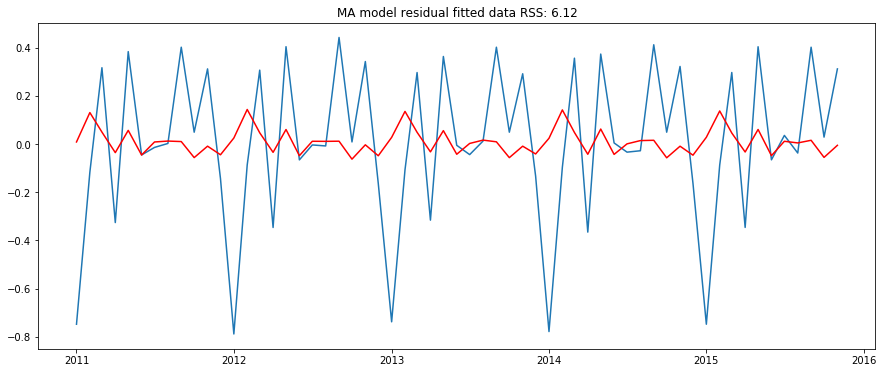

In [435]:
model = ARIMA(ts_log, order=(0, d, q))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA model residual fitted data RSS: %.2f'% math.fsum((results_MA.fittedvalues-ts_log_diff.iloc[:,0])**2))

### ARIMA model
order parameter set (p, d, p)

Text(0.5,1,'ARIMA model residual fitted data RSS = 5.15')

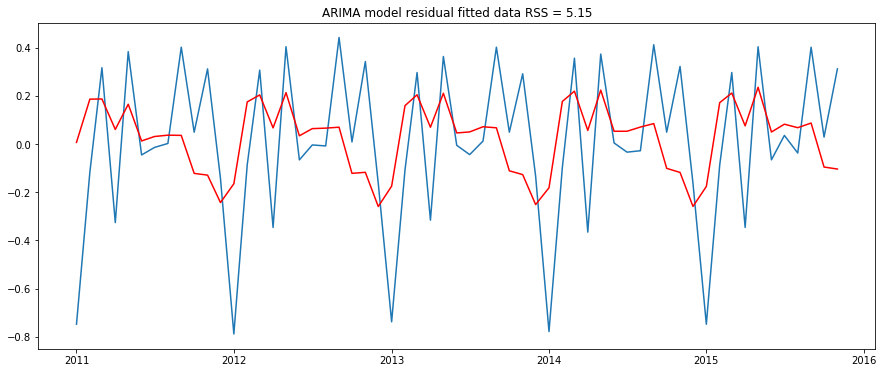

In [434]:
model_ARIMA = ARIMA(ts_log, order=(p, d, q))  
results_ARIMA = model_ARIMA.fit(disp=-1)  
rss = math.fsum((results_ARIMA.fittedvalues-ts_log_diff.iloc[:,0])**2)

plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA model residual fitted data RSS = %.2f'% rss)

Since the ARIMA model has the least residual sum of squares, I will choose this model for the forecast.

### Scale back to the original values
First, I will set the fitted test data to its origianl scale.

Text(0.5,1,'Fitted final values. RMSE: 278062.4439')

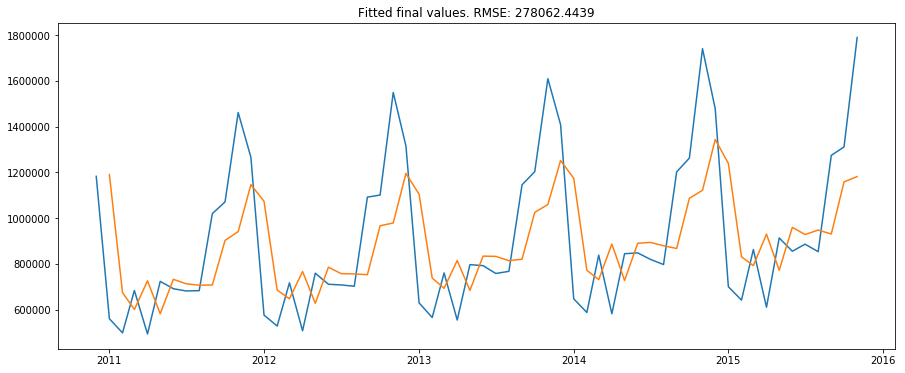

In [424]:
# fitted residual values
fitted_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
shifted = ts_log.shift(Diff_Count)
shifted.dropna(inplace=True)
fitted_with_shift = fitted_ARIMA_diff.add(shifted.iloc[:,0], fill_value=0)
fitted_final = np.exp(fitted_with_shift)
plt.plot(ts_test)
plt.plot(fitted_final)
plt.title('Fitted final values. RMSE: %.4f'% np.sqrt(mean_squared_error(fitted_final, ts_test.iloc[1:,0])))

Now to add the rolling forecast to the plot by predicting one datum at a time. Once a datum is predicted, it is added to the history series for future prediction. Then all data is plotted together.

Text(0.5,1,'ARIMA fit and prediction of 6 years sales. Prediction RMSE = 327001.1690')

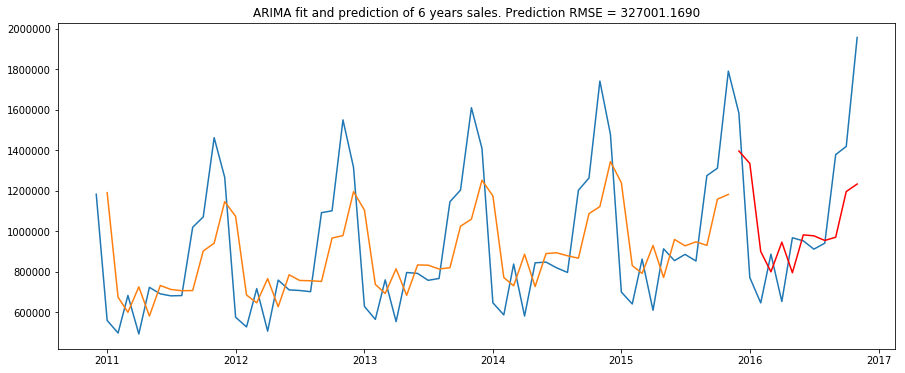

In [412]:
# predict from model
history = ts_log.iloc[:,0]
predictions = list()

for t in range(len(ts_cross_validate)):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit(disp=-1)
    output = model_fit.forecast(1)
    yhat = output[0][0]
    predictions.append(yhat)
    obs = np.log(ts_cross_validate.values[t])
    history = np.append(history, obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

predictions = np.exp(predictions)
error = mean_squared_error(ts_cross_validate.iloc[:,0], predictions)
predictions_final = pd.Series(predictions, index=ts_cross_validate.index, copy=True)

# plot
pyplot.plot(ts.iloc[:,0])
pyplot.plot(fitted_final)
pyplot.plot(predictions_final, color='red')
pyplot.title('ARIMA fit and prediction of 6 years sales. Prediction RMSE = %.4f'% np.sqrt(error))
pyplot.show()


### Conclusions
By going through this time series modeling exercise using ARIMA model, I get some decent fitted and predicted data that shows correct trend and seasonality pattern as in origianl data set. But, the error seems large which indicate the modeling isn't accurate enough. More work can be done to find a better modeling for this set of data. 

There is still one question remains: why the fitted and predicted data is shifted by 1 period? Does that mean when I predict the a future February sales, what I get is for January? Puzzled.

### Acknowledgement

Thanks to the authers of these two webpages:

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

Without their shared knowledge, I won't be able to finish this exercies in a short period of time.

Also thanks to my firends who answered my questions during this exercise process.
